<a href="https://colab.research.google.com/github/santhoshsrivi/study/blob/main/Dissertation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
import seaborn as sns
import pandas as pd 
import numpy as np 
import tensorflow as tf
import os,time,librosa,warnings,glob
import regex as re
from sklearn.metrics import confusion_matrix,classification_report
import librosa.display
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Dense,Input,Add,Flatten,Dropout,Activation,AveragePooling1D,Conv1D
from keras.models import Model,Sequential,load_model
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler,EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import io
warnings.filterwarnings("ignore")

In [ ]:
!pip install ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Audio,HTML
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
warnings.filterwarnings("ignore")

import ffmpeg

In [ ]:
#Function for calculating the total time reqired to execute various function
def calc_time(func):
  def inner(*args, **kwargs):
    st = time.time()
    result = func(*args,**kwargs)
    end = time.time()-st
    print("Total time required: {:.3f} ms".format(end * 1000))
    return result
  return inner

In [ ]:
def ravdess_data():
  #directory of the audio dataset
  ravdess = "/content/gdrive/MyDrive/Audiofiles/audio_speech_actors_01-24/"
  #label ravdess data
  emotion_ravdess = {'01':'neutral','02':'calm','03':'happy','04':'sad','05':'angry','06':'fearful','07':'disgust','08':'surprised'}
  #list to store ravdess emotion
  ravdess_emotion = []
  #list to store ravdess audio path
  ravdess_path = []
  #get subfolders from the path
  ravdess_folder = os.listdir(ravdess)
  for i in ravdess_folder:
    inner_files = os.listdir(ravdess+i+'/')
    for j in inner_files:
      #get the split part which contains the emotion information then append it into lists
      emotion = j.split('-')[2]
      ravdess_path.append(ravdess+i+'/'+j)
      ravdess_emotion.append(emotion_ravdess[emotion])

  #convert to dataframe
  df_ravdess = pd.DataFrame([ravdess_path,ravdess_emotion]).T
  df_ravdess.columns = ["AudioPath","Label"]
  print("length of ravdess dataset",len(df_ravdess))

  return df_ravdess

In [ ]:
#function for getting crema dataset details and labeling
def crema_data():
  #directory of the audio dataset
  crema = "/content/gdrive/MyDrive/Audiofiles/AudioWAV/"
  #label crema data
  emotion_crema = {'SAD':'sad','ANG':'angry','DIS':'disgust','FEA':'fear','HAP':'happy','NEU':'neutral'}
  #list to store crema emotion
  crema_emotion = []
  #list to store crema audio path
  crema_path = []
  #get crema files in directory
  crema_files = os.listdir(crema)
  for i in crema_files:
    emotion = i.split('_')[2]
    crema_emotion.append(emotion_crema[emotion])
    crema_path.append(crema+i)

  #convert to dataframe
  df_crema = pd.DataFrame([crema_path,crema_emotion]).T
  df_crema.columns = ["AudioPath","Label"]
  print("length of crema dataset",len(df_crema))

  return df_crema

In [ ]:
#function for getting tess dataset and labeling
def tess_data():
  #directory of the audio dataset
  tess = "/content/gdrive/MyDrive/Audiofiles/TESS Toronto emotional speech set data/"
  #/content/gdrive/MyDrive/Audiofiles/TESS Toronto emotional speech set data
  tess_emotion = []
  tess_path = []
  tess_folder = os.listdir(tess)
  for i in tess_folder:
    emotion = i.split('_',1)[1]
    inner_files = os.listdir(tess+i+'/')
    for j in inner_files:
      tess_path.append(tess+i+'/'+j)
      tess_emotion.append(emotion)

  #convert to dataframe
  df_tess = pd.DataFrame([tess_path,tess_emotion]).T
  df_tess.columns = ["AudioPath","Label"]
  print("length of tess dataset",len(df_tess))

  return df_tess

In [ ]:
#function to get savee dataset and labeling
def savee_data():
  #directory of the audio dataset
  savee = "/content/gdrive/MyDrive/Audiofiles/ALL/"
  emotion_savee = {'a':'anger','d':'disgust','f':'fear','h':'happiness','n':'neutral','sa':'sadness','su':'surprise'}
  savee_emotion = []
  savee_path = []
  savee_files = os.listdir(savee)
  for i in savee_files:
    emotion = i.split('_')[1]
    emotion = re.match(r"([a-z]+)([0-9]+)",emotion)[1]
    savee_emotion.append(emotion_savee[emotion])
    savee_path.append(savee+i)

  #convert to dataframe
  df_savee = pd.DataFrame([savee_path,savee_emotion]).T
  df_savee.columns = ["AudioPath","Label"]
  print("length of savee dataset",len(df_savee))

  return df_savee

In [ ]:
def fetch_data():
  df_ravdess = ravdess_data()
  df_crema = crema_data()
  df_tess = tess_data()
  df_savee = savee_data()

  dataframes = [df_ravdess,df_crema,df_tess,df_savee]
  combined = pd.concat(dataframes)
  combined.reset_index(drop=True,inplace=True)

  combined.to_csv("/content/gdrive/MyDrive/Audiofiles/preprocesseddata.csv",index=False,header=True)
  print("Total length of the dataset is {}".format(len(combined)))
  return combined

In [ ]:
#Below are four data agumentation functions for noise, stretch, shift, pitch
#function to add noise to audio
def noise(data):
  noise_amp = 0.035*np.random.uniform()*np.amax(data)
  data = data + noise_amp*np.random.normal(size=data.shape[0])
  return data

In [ ]:
#Function to strech audio
def stretch(data, rate=0.8):
  return librosa.effects.time_stretch(data, rate)

In [ ]:
#Function to shift audio range
def shift(data):
  shift_range = int(np.random.uniform(low=-5,high=5)*1000)
  return np.roll(data,shift_range)

In [ ]:
#Function to Change Pitch
def pitch(data,sampling_rate,pitch_factor=0.7):
  return librosa.effects.pitch_shift(data,sampling_rate,pitch_factor)

##Feature Extraction

In [ ]:
def feature_extract(data,sampling_rate):

  #zero crossing rate
  result = np.array([])
  zero_cross_rate = np.mean(librosa.feature.zero_crossing_rate(y=data).T,axis=0)
  result = np.hstack((result,zero_cross_rate))

  #Chroma_shift
  stft = np.abs(librosa.stft(data))
  chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr = sampling_rate).T,axis=0)
  result = np.hstack((result,chroma_stft))

  #Mel Frequency cepstral coefficients
  mfcc = np.mean(librosa.feature.mfcc(y=data,sr=sampling_rate).T,axis=0)
  result = np.hstack((result,mfcc))

  #Root Mean Square Energy
  rms = np.mean(librosa.feature.rms(y=data).T,axis=0)
  result = np.hstack((result,rms))

  #Mel spectrogram
  mel = np.mean(librosa.feature.melspectrogram(y=data,sr=sampling_rate).T,axis=0)
  result = np.hstack((result,mel))

  #Spectral Rolloff
  rollof = np.mean(librosa.feature.spectral_rolloff(y=data,sr=sampling_rate).T,axis=0)
  result = np.hstack((result,rollof))

  #Spectral Centroids
  centroid = np.mean(librosa.feature.spectral_centroid(y=data,sr=sampling_rate).T,axis=0)
  result = np.hstack((result,centroid))

  #Spectral Contrast
  contrast = np.mean(librosa.feature.spectral_contrast(y=data,sr=sampling_rate).T,axis=0)
  result = np.hstack((result,contrast))

  #Bandwidth
  bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=data,sr=sampling_rate).T,axis=0)
  result=np.hstack((result,bandwidth))

  #Tonnetz
  tonnetz = np.mean(librosa.feature.tonnetz(y=data,sr=sampling_rate).T,axis=0)
  result= np.hstack((result, tonnetz))

  return result

In [ ]:
#function is used to get all augmented plus original features for given audio file
def get_features(path):
  #setting duration and path

  data,sample_rate = librosa.load(path, duration=2.5, offset=0.6)

  #audio features without augmentation
  result1 = feature_extract(data,sample_rate)
  result = np.array(result1)

  #Audio features with noise
  noise_data = noise(data)
  result2 = feature_extract(noise_data,sample_rate)
  result = np.vstack((result,result2))

  #Audio features with streching and pitching
  new_data = stretch(data)
  data_stretch_pitch = pitch(new_data,sample_rate)
  result3 = feature_extract(data_stretch_pitch,sample_rate)
  result = np.vstack((result,result3))

  return result

In [ ]:
import tqdm

def Audio_features_extract():
  df = fetch_data()
  X_data, Y_label = [], []
  for i in tqdm.tqdm(range(len(df["AudioPath"]))):
    path = df["AudioPath"][i]
    emotion = df["Label"][i]
    feature = get_features(path)
    for ele in feature:
      X_data.append(ele)
      Y_label.append(emotion)

  Features = pd.DataFrame(X_data)
  Features['Label'] = Y_label
  Features.to_csv('/content/gdrive/MyDrive/Audiofiles/Audio_features_All_pr_new.csv',index=False)

Audio_features_extract()

length of ravdess dataset 1440
length of crema dataset 7442
length of tess dataset 2800
length of savee dataset 480
Total length of the dataset is 12162


100%|██████████| 12162/12162 [5:52:02<00:00,  1.74s/it]


In [ ]:
def plotgraph_new(history):
    plt.figure(figsize=[8,6])
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.legend(loc='best')
    plt.xlabel('Epochs')
    plt.ylabel('Loss and Accuracy')
    plt.title('Training and Validation Loss and Accuracy')
    plt.show()


In [ ]:
def additional_preprocess(filepath):
  #read the csv file of extrated features
  df = pd.read_csv(filepath)
  print("\nlabels or emotions present in dataset\n",df["Label"].unique())
  #replace label names with name common for each emotion 
  #this is done to maintain uniformity of label names
  df["Label"] = df["Label"].str.replace("sadness", "sad", case = True)
  df["Label"] = df["Label"].str.replace("happiness", "happy", case = True)
  df["Label"] = df["Label"].str.replace("Fear", "fear", case = True)
  df["Label"] = df["Label"].str.replace("Sad", "sad", case = True)
  df["Label"] = df["Label"].str.replace("Pleasant_surprise", "surprise", case = True)
  df["Label"] = df["Label"].str.replace("pleasant_surprised", "surprise", case = True)
  df["Label"] = df["Label"].str.replace("surprised", "surprise", case = True)
  df["Label"] = df["Label"].str.replace("fearful", "fear", case = True)
  df["Label"] = df["Label"].str.replace("anger", "angry", case = True)
  #drop labels surprized and clam
  #these label dosent contain sufficent amount of data and can lead to missclassification
  sns.countplot(x=df["Label"], data=df['Label'])
  print("\nUnique count of labels or emotions\n",df["Label"].value_counts())
  #drop labels or emotions which can lead to misclassifications
  df.drop((np.where(df['Label'].isin(["surprise","calm"]))[0]), inplace = True)
  print("\nUnique count of labels or emotions after dropping selected labels\n",df["Label"].value_counts())
  print("\nlength of the total data is {}".format(len(df)))
  return df

In [ ]:
def secondary_preprocess(filepath):
  df = pd.read_csv(filepath)
  print("\n Emotions present in dataset\n",df["Label"].unique())

  df["Label"] = df["Label"].str.replace("sadness","sad",case = True)
  df["Label"] = df["Label"].str.replace("happiness","happy",case = True)
  df["Label"] = df["Label"].str.replace("Fear","fear",case = True)
  df["Label"] = df["Label"].str.replace("Sad","sad",case = True)
  df["Label"] = df["Label"].str.replace("Pleasant_surprise","surprise",case = True)
  df["Label"] = df["Label"].str.replace("pleasant_surprised","surprise",case = True)
  df["Label"] = df["Label"].str.replace("surprised","surprise",case = True)
  df["Label"] = df["Label"].str.replace("fearful","fear",case = True)
  df["Label"] = df["Label"].str.replace("anger","angry",case = True)
  sns.countplot(x=df["Label"], data=df['Label'])


  print("Number of unique emotions ",df["Label"].value_counts())
  df.drop((np.where(df['Label'].isin(["surprise","calm"]))[0]),inplace=True)
  print("\nUnique count of labels or emotions after dropping selected labels\n",df["Label"].value_counts())
  print("\nlength of the total data is {}".format(len(df)))
  return df

In [ ]:
#80:20 train-test split

def audio_features_final():
  df = additional_preprocess("/content/gdrive/MyDrive/Audiofiles/Audio_features_All_pr.csv")
  #get all the aduio features as numpy array from the dataframe 
  #last column is label so last column is not fetched only 0to:-1
  data=df[df.columns[0:-1]].values
  #perform one hot encoding on labels
  encoder = OneHotEncoder()
  #fetch the last column of labels and perform one hot encoding on them
  label=df["Label"].values
  label = encoder.fit_transform(np.array(label).reshape(-1,1)).toarray()
  #min max scaler is used to normalize the data
  scaler = MinMaxScaler()
  data=scaler.fit_transform(data)
  #split the dataframe into train and test 80% train, 10% validation and 10% test datasets
  x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.20, random_state=42,shuffle=True)
  x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=42, shuffle=True)
  print("\nlength of train data is {}, test data is {} and validation set is {}".format(len(x_train),len(x_test),len(x_val))) 
  print("\n shape of train features and label is {}".format(x_train.shape, y_train.shape))
  print("\n shape of test features and label is {}".format(x_test.shape, y_test.shape))
  print("\n shape of validation features and label is {}".format(x_val.shape,y_val.shape))
  return x_train, x_test, y_train, y_test, x_val, y_val, encoder

In [ ]:
#75:25 train - test split
def audio_features_final():
  df = additional_preprocess("/content/gdrive/MyDrive/Audiofiles/Audio_features_All_pr.csv")
  #get all the aduio features as numpy array from the dataframe 
  #last column is label so last column is not fetched only 0to:-1
  data=df[df.columns[0:-1]].values
  #perform one hot encoding on labels
  encoder = OneHotEncoder()
  #fetch the last column of labels and perform one hot encoding on them
  label=df["Label"].values
  label = encoder.fit_transform(np.array(label).reshape(-1,1)).toarray()
  #min max scaler is used to normalize the data
  scaler = MinMaxScaler()
  data=scaler.fit_transform(data)
  #split the dataframe into train and test 80% train, 10% validation and 10% test datasets
  x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.25, random_state=42,shuffle=True)
  x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=42, shuffle=True)
  print("\nlength of train data is {}, test data is {} and validation set is {}".format(len(x_train),len(x_test),len(x_val))) 
  print("\n shape of train features and label is {}".format(x_train.shape, y_train.shape))
  print("\n shape of test features and label is {}".format(x_test.shape, y_test.shape))
  print("\n shape of validation features and label is {}".format(x_val.shape,y_val.shape))
  return x_train, x_test, y_train, y_test, x_val, y_val, encoder

In [ ]:

def audio_feature_final():
  df = secondary_preprocess("/content/gdrive/MyDrive/Audiofiles/Audio_features_All_pr.csv")
  data = df[df.columns[0:-1]].values
  encoder = OneHotEncoder()
  label = df["Label"].values
  label = encoder.fit_transform(np.array(label).reshape(-1,1)).toarray()
  scaler = MinMaxScaler()
  data = scaler.fit_transform(data)
  x_train, x_test, y_train, y_test = train_test_split(data,label,test_size=0.20,random_state = 42,shuffle=True)
  x_test, x_val, y_test, y_val = train_test_split(x_test,y_test,test_size=0.50,random_state=42,shuffle=True)
  print("\nLength of train data is {}, test data is {}, val data is {}".format(len(x_train),len(x_test),len(x_val)))
  print("\nShape of train features and label is {}".format(x_train.shape, y_train.shape))
  print("\nShape of test features and label si {}".format(x_test.shape, y_test.shape))
  print("\nShape of validation features and label is {}".format(x_val.shape, y_val.shape))
  return x_train, x_test, y_train, y_test, x_val, y_val, encoder

In [ ]:
##Model 1

def emotion_recognition_model(x_train,y_train,x_val,y_val):
  #reduce the laerning rate if plateau is encountered
  reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.001)
  #early stopping method is used to montior the loss if there are no significant reductions in loss then halt the training
  es = EarlyStopping(monitor='loss', patience=20)
  #checkpoint to save the best model with highest validation accuracy
  filepath = "/content/gdrive/MyDrive/Audiofiles/emotion-recognition.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  #create a combined list of reduce learning rate, early stopping and checkpoint
  callbacks_list = [reduce_lr,es,checkpoint]
  def residual_block(x, filters, conv_num=3, activation="relu"):
    #fucntion is used to create residual blocks and add residual blocks
    s = Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
      x = Conv1D(filters, 3, padding="same")(x)
      x = Activation(activation)(x)
    x = Conv1D(filters, 3, padding="same")(x)
    x = Add()([x, s])
    x = Activation(activation)(x)
    return x
  #fucntion to build the model 
  def build_model():
    inputs =  Input(shape=(x_train.shape[1],1))
    x = Dense(256, activation="relu")(inputs)
    x = residual_block(x, 16, 2)
    x = residual_block(x, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)
    #perform the average pooling after last residual block 
    x = AveragePooling1D(pool_size=3, strides=3)(x)
    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    outputs = Dense(6, activation="softmax", name="output")(x)
    return Model(inputs=inputs, outputs=outputs)

  res_model = build_model() 
  #display the summary of the model
  res_model.summary() 
  #complie the model
  res_model.compile(loss='categorical_crossentropy',optimizer = Adam(lr=1e-4, decay=1e-4 / 50) , metrics=['accuracy'])
  history = res_model.fit(np.expand_dims(x_train,-1),y_train,
                validation_data=(np.expand_dims(x_val, -1), y_val), 
                epochs=500,
                batch_size=32,
                shuffle=True,
                workers=50,
                verbose=1,
                use_multiprocessing=True,
                callbacks = callbacks_list)
  
  #plot loss and accuracy curves
  plotgraph_new(history)


In [ ]:
##Model 2
from keras.optimizers import RMSprop

def emotion_recognition_model_new(x_train,y_train,x_val,y_val):
  #reduce the laerning rate if plateau is encountered
  reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.001)
  #early stopping method is used to montior the loss if there are no significant reductions in loss then halt the training
  es = EarlyStopping(monitor='loss', patience=20)
  #checkpoint to save the best model with highest validation accuracy
  filepath = "/content/gdrive/MyDrive/Audiofiles/emotion-recognition.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  #create a combined list of reduce learning rate, early stopping and checkpoint
  callbacks_list = [reduce_lr,es,checkpoint]
  def residual_block(x, filters, conv_num=3, activation="relu"):
    #fucntion is used to create residual blocks and add residual blocks
    s = Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
      x = Conv1D(filters, 3, padding="same")(x)
      x = Activation(activation)(x)
    x = Conv1D(filters, 3, padding="same")(x)
    x = Add()([x, s])
    x = Activation(activation)(x)
    return x
  #fucntion to build the model 
  def build_model():
    inputs =  Input(shape=(x_train.shape[1],1))
    x = Dense(256, activation="relu")(inputs)
    x = residual_block(x, 16, 2)
    x = residual_block(x, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)
    #x = residual_block(x, 256, 3)
    x  = Dropout(0.5)(x)
    #perform the average pooling after last residual block 
    x = AveragePooling1D(pool_size=3, strides=3)(x)
    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    outputs = Dense(6, activation="softmax", name="output")(x)
    return Model(inputs=inputs, outputs=outputs)

  res_model = build_model() 
  #display the summary of the model
  res_model.summary() 
  #complie the model
  #from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define the learning rate scheduler
  #lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)

# Define the early stopping
  #early_stopper = EarlyStopping(monitor='val_loss', patience=20)

# Use different optimizer
  optimizer = RMSprop(lr=1e-4)

# Add dropout
 

  res_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Pass the callbacks to the fit function
  history = res_model.fit(np.expand_dims(x_train,-1),y_train,
                validation_data=(np.expand_dims(x_val, -1), y_val), 
                epochs=500,
                batch_size=64,
                shuffle=True,
                workers=50,
                verbose=1,
                use_multiprocessing=True,
                callbacks=callbacks_list)

  
  #plot loss and accuracy curves
  plotgraph_new(history)


In [ ]:

def evaluate_model(x_train, x_test, y_train, y_test, x_val, y_val):
  #load the best model
  model = load_model("/content/gdrive/MyDrive/Audiofiles/emotion-recognition.hdf5")
  #evaluate training accuracy 
  _,train_acc = model.evaluate(np.expand_dims(x_train,-1),y_train, batch_size=1)
  #evaluate testing acuracy
  _,test_acc = model.evaluate(np.expand_dims(x_test,-1),y_test, batch_size=1)
  #evaluate validation accuracy
  _,val_acc = model.evaluate(np.expand_dims(x_val,-1),y_val, batch_size=1)
  print("\n**********************************************")
  print("\n Training accuracy of the model is {}".format(np.round(float(train_acc*100),2)))
  print("\n Testing accuracy of the model is {}".format(np.round(float(test_acc*100),2)))
  print("\n Validation accuracy of the model is {}".format(np.round(float(val_acc*100),2)))
  print("**********************************************")
  #predict the outcome of the model
  y_pred = model.predict(x_test)
  y_pred=np.argmax(y_pred, axis=1)
  y_test=np.argmax(y_test, axis=1)
  #View the classification report for test data and predictions
  print("\nClassification report for Emotion Recognition")
  print(classification_report(y_test, y_pred))  
  #View confusion matrix for test data and predictions
  print("\nConfusion matrix for Emotion Recognition")
  print(confusion_matrix(y_test, y_pred))
  print("*****************************")



labels or emotions present in dataset
 ['surprised' 'neutral' 'disgust' 'fearful' 'sad' 'calm' 'happy' 'angry'
 'fear' 'Fear' 'Sad' 'Pleasant_surprise' 'pleasant_surprised' 'happiness'
 'anger' 'surprise' 'sadness']

Unique count of labels or emotions
 disgust     5769
fear        5769
sad         5769
happy       5769
angry       5769
neutral     5109
surprise    1956
calm         576
Name: Label, dtype: int64

Unique count of labels or emotions after dropping selected labels
 disgust    5769
fear       5769
sad        5769
happy      5769
angry      5769
neutral    5109
Name: Label, dtype: int64

length of the total data is 33954

length of train data is 25465, test data is 4244 and validation set is 4245

 shape of train features and label is (25465, 178)

 shape of test features and label is (4244, 178)

 shape of validation features and label is (4245, 178)
Model: "model"
__________________________________________________________________________________________________
 Layer (ty

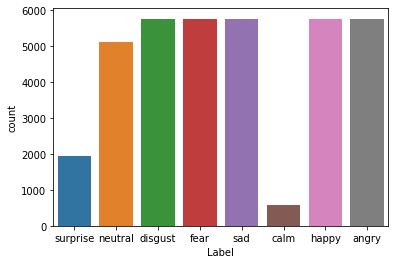

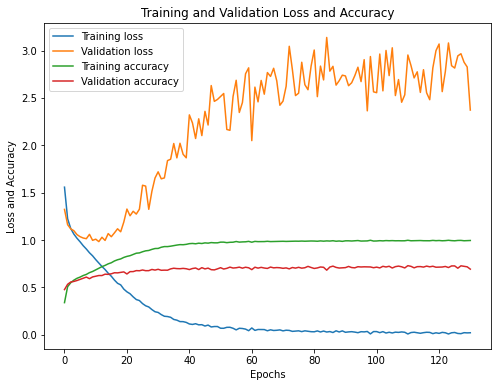

4245/4245 [==============================] - 26s 6ms/step - loss: 2.9532 - accuracy: 0.7298

**********************************************

 Training accuracy of the model is 99.98

 Testing accuracy of the model is 75.14

 Validation accuracy of the model is 72.98
**********************************************
133/133 [==============================] - 3s 17ms/step

Classification report for Emotion Recognition
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       727
           1       0.70      0.70      0.70       692
           2       0.77      0.74      0.75       691
           3       0.76      0.73      0.74       768
           4       0.72      0.73      0.73       622
           5       0.73      0.78      0.76       744

    accuracy                           0.75      4244
   macro avg       0.75      0.75      0.75      4244
weighted avg       0.75      0.75      0.75      4244


Confusion matrix for Emotion Recognitio

In [ ]:
#Model 1 with 75:25 train test split and Adam optimizer

def main():
  #get train,test data and labels 
  x_train, x_test, y_train, y_test, x_val, y_val, encoder = audio_features_final()
  #call the emotion recognition model
  emotion_recognition_model(x_train,y_train,x_val,y_val)
  #evaluate the model performance
  evaluate_model(x_train, x_test, y_train, y_test, x_val, y_val)

if __name__:main()


labels or emotions present in dataset
 ['surprised' 'neutral' 'disgust' 'fearful' 'sad' 'calm' 'happy' 'angry'
 'fear' 'Fear' 'Sad' 'Pleasant_surprise' 'pleasant_surprised' 'happiness'
 'anger' 'surprise' 'sadness']

Unique count of labels or emotions
 disgust     5769
fear        5769
sad         5769
happy       5769
angry       5769
neutral     5109
surprise    1956
calm         576
Name: Label, dtype: int64

Unique count of labels or emotions after dropping selected labels
 disgust    5769
fear       5769
sad        5769
happy      5769
angry      5769
neutral    5109
Name: Label, dtype: int64

length of the total data is 33954

length of train data is 25465, test data is 4244 and validation set is 4245

 shape of train features and label is (25465, 178)

 shape of test features and label is (4244, 178)

 shape of validation features and label is (4245, 178)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


398/398 [==============================] - ETA: 0s - loss: 1.6586 - accuracy: 0.2852
Epoch 1: val_accuracy improved from -inf to 0.40495, saving model to /content/gdrive/MyDrive/Audiofiles/emotion-recognition.hdf5
398/398 [==============================] - 21s 38ms/step - loss: 1.6586 - accuracy: 0.2852 - val_loss: 1.4739 - val_accuracy: 0.4049 - lr: 1.0000e-04
Epoch 2/500
397/398 [============================>.] - ETA: 0s - loss: 1.3725 - accuracy: 0.4478
Epoch 2: val_accuracy improved from 0.40495 to 0.48363, saving model to /content/gdrive/MyDrive/Audiofiles/emotion-recognition.hdf5
398/398 [==============================] - 11s 28ms/step - loss: 1.3722 - accuracy: 0.4479 - val_loss: 1.2905 - val_accuracy: 0.4836 - lr: 1.0000e-04
Epoch 3/500
398/398 [==============================] - ETA: 0s - loss: 1.2363 - accuracy: 0.5049
Epoch 3: val_accuracy improved from 0.48363 to 0.52391, saving model to /content/gdrive/MyDrive/Audiofiles/emotion-recognition.hdf5
398/398 [===================

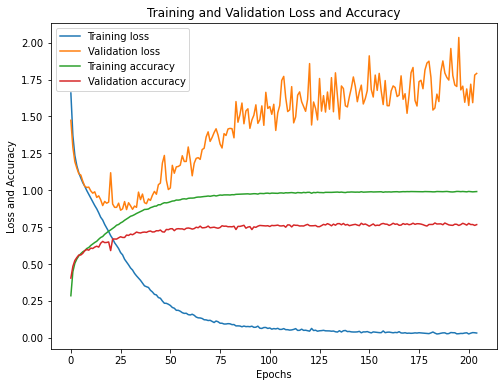

4245/4245 [==============================] - 19s 5ms/step - loss: 1.5571 - accuracy: 0.7781

**********************************************

 Training accuracy of the model is 99.97

 Testing accuracy of the model is 79.22

 Validation accuracy of the model is 77.81
**********************************************
133/133 [==============================] - 1s 6ms/step

Classification report for Emotion Recognition
              precision    recall  f1-score   support

           0       0.87      0.86      0.87       727
           1       0.72      0.76      0.74       692
           2       0.77      0.77      0.77       691
           3       0.82      0.76      0.79       768
           4       0.76      0.80      0.78       622
           5       0.81      0.80      0.80       744

    accuracy                           0.79      4244
   macro avg       0.79      0.79      0.79      4244
weighted avg       0.79      0.79      0.79      4244


Confusion matrix for Emotion Recognition

In [ ]:
#Model with 75:25 train test split and RMSProp optimizer

def main():
  #get train,test data and labels 
  x_train, x_test, y_train, y_test, x_val, y_val, encoder = audio_features_final()
  #call the emotion recognition model
  emotion_recognition_model_new(x_train,y_train,x_val,y_val)
  #evaluate the model performance
  evaluate_model(x_train, x_test, y_train, y_test, x_val, y_val)

if __name__:main()


labels or emotions present in dataset
 ['surprised' 'neutral' 'disgust' 'fearful' 'sad' 'calm' 'happy' 'angry'
 'fear' 'Fear' 'Sad' 'Pleasant_surprise' 'pleasant_surprised' 'happiness'
 'anger' 'surprise' 'sadness']

Unique count of labels or emotions
 disgust     5769
fear        5769
sad         5769
happy       5769
angry       5769
neutral     5109
surprise    1956
calm         576
Name: Label, dtype: int64

Unique count of labels or emotions after dropping selected labels
 disgust    5769
fear       5769
sad        5769
happy      5769
angry      5769
neutral    5109
Name: Label, dtype: int64

length of the total data is 33954

length of train data is 27163, test data is 3395 and validation set is 3396

 shape of train features and label is (27163, 178)

 shape of test features and label is (3395, 178)

 shape of validation features and label is (3396, 178)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (

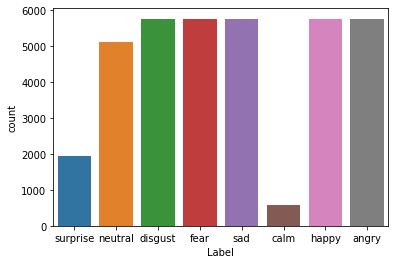

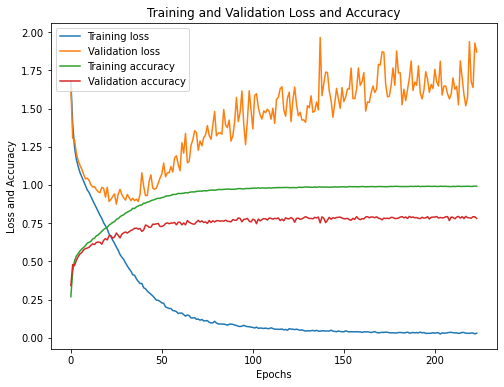

3396/3396 [==============================] - 19s 5ms/step - loss: 1.5179 - accuracy: 0.7942

**********************************************

 Training accuracy of the model is 99.99

 Testing accuracy of the model is 80.41

 Validation accuracy of the model is 79.42
**********************************************
107/107 [==============================] - 1s 6ms/step

Classification report for Emotion Recognition
              precision    recall  f1-score   support

           0       0.83      0.88      0.86       588
           1       0.80      0.74      0.77       559
           2       0.84      0.76      0.79       554
           3       0.81      0.81      0.81       620
           4       0.76      0.83      0.79       513
           5       0.78      0.81      0.80       561

    accuracy                           0.80      3395
   macro avg       0.80      0.80      0.80      3395
weighted avg       0.81      0.80      0.80      3395


Confusion matrix for Emotion Recognition

In [ ]:
## RMSProp batch 64 model 80:20 split

def main():
  #get train,test data and labels 
  x_train, x_test, y_train, y_test, x_val, y_val, encoder = audio_features_final()
  #call the emotion recognition model
  emotion_recognition_model_new(x_train,y_train,x_val,y_val)
  #evaluate the model performance
  evaluate_model(x_train, x_test, y_train, y_test, x_val, y_val)

if __name__:main()


labels or emotions present in dataset
 ['surprised' 'neutral' 'disgust' 'fearful' 'sad' 'calm' 'happy' 'angry'
 'fear' 'Fear' 'Sad' 'Pleasant_surprise' 'pleasant_surprised' 'happiness'
 'anger' 'surprise' 'sadness']

Unique count of labels or emotions
 disgust     5769
fear        5769
sad         5769
happy       5769
angry       5769
neutral     5109
surprise    1956
calm         576
Name: Label, dtype: int64

Unique count of labels or emotions after dropping selected labels
 disgust    5769
fear       5769
sad        5769
happy      5769
angry      5769
neutral    5109
Name: Label, dtype: int64

length of the total data is 33954

length of train data is 27163, test data is 3395 and validation set is 3396

 shape of train features and label is (27163, 178)

 shape of test features and label is (3395, 178)

 shape of validation features and label is (3396, 178)


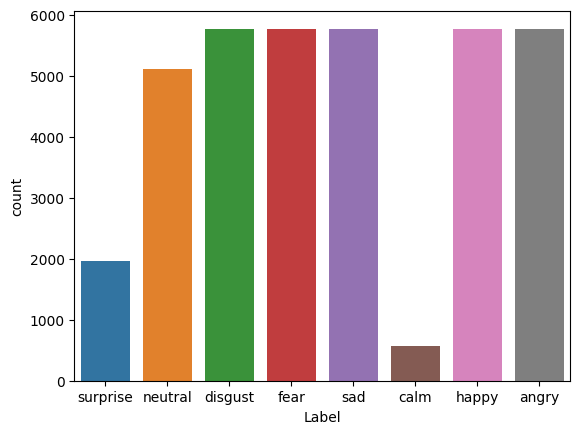

In [ ]:
x_train, x_test, y_train, y_test, x_val, y_val, encoder = audio_features_final()

In [ ]:
#mapping of the one hot ecoding with respect to their labels
print("\none hot encoding array\n",np.unique(y_train,axis=0))
print("\nOne hot encoding mapping to actual label\n",encoder.inverse_transform(np.unique(y_train,axis=0)))


one hot encoding array
 [[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]

One hot encoding mapping to actual label
 [['sad']
 ['neutral']
 ['happy']
 ['fear']
 ['disgust']
 ['angry']]


In [ ]:
#Fourier transform

import numpy as np
from scipy.fft import rfft, irfft

def get_audio():
    display(HTML(AUDIO_HTML))
    data = eval_js("data")
    binary = b64decode(data.split(',')[1])
  
    process = (ffmpeg
        .input('pipe:0')
        .output('pipe:1', format='wav')
        .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
    )
    output, err = process.communicate(input=binary)
  
    riff_chunk_size = len(output) - 8
    # Break up the chunk size into four bytes, held in b.
    q = riff_chunk_size
    b = []
    for i in range(4):
        q, r = divmod(q, 256)
        b.append(r)

    # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
    riff = output[:4] + bytes(b) + output[8:]

    sr, audio = wav_read(io.BytesIO(riff))

    return audio, sr


In [ ]:
#this javascript is used to tell colab cell to open microphone and record audio
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press the button to start");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Capturing... press to terminate";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the speech signal... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""
#fucntion is used to invoke microphone on laptop and record the voice 
#it used javascript to work as colab dosent have inbuilt method to record audio



In [ ]:
def get_features_recorded(data,sr): 

  #get features for recorded audio using mircophone
  res1 = feature_extract(data,sr)
  result = np.array(res1)
  
  #get audio features with noise
  noise_data = noise(data)
  res2 = feature_extract(noise_data,sr)
  result = np.vstack((result, res2))
    
  #get audio features with stretching and pitching
  new_data = stretch(data)
  data_stretch_pitch = pitch(new_data, sr)
  res3 = feature_extract(data_stretch_pitch,sr)
  result = np.vstack((result, res3))
  
  return result

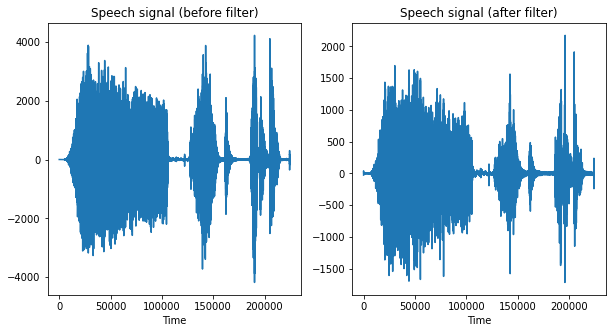

1/1 [==============================] - 1s 744ms/step
\The predicted Emotion for the speech signal Using Microphone is ['fear']


<Figure size 432x288 with 0 Axes>

In [ ]:
realtime_n(encoder)

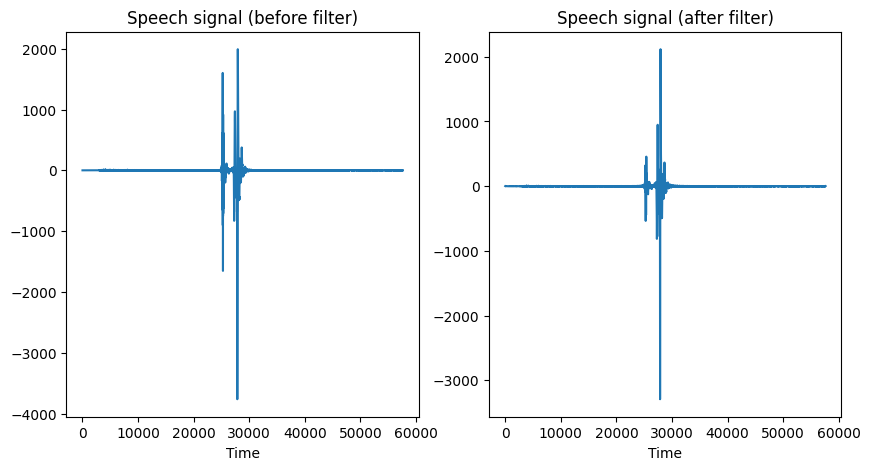

TypeError: ignored

<Figure size 640x480 with 0 Axes>

In [ ]:
realtime_n(encoder)

In [ ]:
import numpy as np
from scipy.fft import rfft, irfft
import matplotlib.pyplot as plt

def realtime_n(encoder):
  
  #load the best model
  res_model = load_model("/content/gdrive/MyDrive/Audiofiles/emotion-recognition.hdf5")

  #record the audio
  audio, sr = get_audio()
  


  #save audio in a file 
  files = []
  os.chdir('/content/gdrive/MyDrive/Audiofiles/realtimetested')
  for file in glob.glob("*.npy"):
    files.append(file)

  #save the audio file for reference
  np.save('/content/gdrive/MyDrive/Audiofiles/realtimetested/audiorec{}.npy'.format(len(files)),audio)
  
  #plot the recorded audio
  plt.figure(figsize=(10,5))
  plt.subplot(1, 2, 1)
  plt.title('Speech signal (before filter)')
  plt.xlabel('Time')
  plt.plot(audio)

  #apply the Fourier transform filter to remove noise
  fourier = rfft(audio)
  frequencies = np.fft.rfftfreq(len(audio), d=1.0/sr)
  noise_freq = (frequencies > 1000) & (frequencies < 8000)
  fourier[noise_freq] = 0
  audio_filtered = irfft(fourier)

  #plot the filtered audio
  plt.subplot(1, 2, 2)
  plt.title('Speech signal (after filter)')
  plt.xlabel('Time')
  plt.plot(audio_filtered)

  plt.show()
  #save the plot of audio file
  plt.savefig("audiorec{}.png".format(len(files)))

  #convert int to float
  audio_filtered = audio_filtered.astype('float')
  #get audio features from the recorded voice
  feature = get_features_recorded(audio_filtered,sr)
  #apply min max scaling
  scaler = MinMaxScaler()
  feature = scaler.fit_transform(feature)
  #get the predicted label
  label=res_model.predict(feature)
  #get the label information by reversing one hot encoded output
  label_predicted=encoder.inverse_transform(label)
  print("\The predicted Emotion for the speech signal Using Microphone is {}".format(label_predicted[0]))
  #create a dataframe for recorded audio features
  df = pd.DataFrame(index=range(0,3),columns=['path','label','audio'])
  for i in range(0,3):
    df["path"][i] = '/content/gdrive/MyDrive/Audiofiles/realtimetested/audiorec{}.npy'.format(len(files))
    df["label"][i] = label_predicted[i]
    df["audio"][i] = feature[i]

  #store the real time predicted features in a csv file
  df.to_csv('/content/gdrive/MyDrive/Audiofiles/realtimetested/real_time_predicted_audio_features.csv', mode='a', index=False)


In [ ]:
import numpy as np
from scipy.fft import rfft, irfft
import matplotlib.pyplot as plt

def realtime(encoder):
  
  #load the best model
  res_model = load_model("/content/gdrive/MyDrive/Audiofiles/emotion-recognition.hdf5")

  #record the audio
  audio, sr = get_audio()
  #save audio in a file 
  files = []
  os.chdir('/content/gdrive/MyDrive/Audiofiles/realtimetested')
  for file in glob.glob("*.npy"):
    files.append(file)

  #save the audio file for reference
  np.save('/content/gdrive/MyDrive/Audiofiles/realtimetested/audiorec{}.npy'.format(len(files)),audio)
  #plot the recorded audio
  plt.figure(figsize=(10,5))
  plt.subplot(1, 2, 1)
  plt.title('Speech signal (before filter)')
  plt.xlabel('Time')
  plt.plot(audio)

  #apply the Fourier transform filter to remove noise
  fourier = rfft(audio)
  frequencies = np.fft.rfftfreq(len(audio), d=1.0/sr)
  noise_freq = (frequencies > 1000) & (frequencies < 8000)
  fourier[noise_freq] = 0
  audio_filtered = irfft(fourier)

  #plot the filtered audio
  plt.subplot(1, 2, 2)
  plt.title('Speech signal (after filter)')
  plt.xlabel('Time')
  plt.plot(audio_filtered)

  plt.show()
  #save the plot of audio file
  plt.savefig("audiorec{}.png".format(len(files)))

  #convert int to float
  audio_filtered = audio_filtered.astype('float')
  #get audio features from the recorded voice
  feature = get_features_recorded(audio_filtered,sr)
  #apply min max scaling
  scaler = MinMaxScaler()
  feature = scaler.fit_transform(feature)
  #get the predicted label
  label=res_model.predict(feature)
  #get the label information by reversing one hot encoded output
  label_predicted=encoder.inverse_transform(label)
  print("\The predicted Emotion for the speech signal Using Microphone is {}".format(label_predicted[0]))
  #create a dataframe for recorded audio features
  df = pd.DataFrame(index=range(0,3),columns=['path','label','audio'])
  for i in range(0,3):
    df["path"][i] = '/content/gdrive/MyDrive/Audiofiles/realtimetested/audiorec{}.npy'.format(len(files))
    df["label"][i] = label_predicted[i]
    df["audio"][i] = feature[i]

  #store the real time predicted features in a csv file
  df.to_csv('/content/gdrive/MyDrive/Audiofiles/realtimetested/real_time_predicted_audio_features.csv', mode='a', index=False)


In [ ]:
def test_realtime(encoder):
  
  #load the best model
  res_model = load_model("/content/gdrive/MyDrive/Audiofiles/emotion-recognition.hdf5")

  #record the aduio
  audio, sr = get_audio()
  #save audio in a file 
  files = []
  os.chdir('/content/gdrive/MyDrive/Audiofiles/realtimetested')
  for file in glob.glob("*.npy"):
	  files.append(file)

  #save the audio file for reference
  np.save('/content/gdrive/MyDrive/Audiofiles/realtimetested/audiorec{}.npy'.format(len(files)),audio)
  #plot the recorded audio
  plt.figure(figsize=(5,5))
  plt.title('Speech signal')
  plt.xlabel('Time')
  plt.plot(audio)
  plt.show()
  #save the plot of audio file
  plt.savefig("audiorec{}.png".format(len(files)))
  #convert int to float
  audio = audio.astype('float')
  #get audio features from the recorded voice
  feature = get_features_recorded(audio,sr)
  #apply min max scaling
  scaler = MinMaxScaler()
  feature = scaler.fit_transform(feature)
  #get the predicted label
  label=res_model.predict(feature)
  #get the label information by reversing one hot encoded output
  label_predicted=encoder.inverse_transform(label)
  print("\The predicted Emotion for the speech signal Using Microphone is {}".format(label_predicted[0]))
  #create a dataframe for recorded aduio features
  df = pd.DataFrame(index=range(0,3),columns=['path','label','audio'])
  for i in range(0,3):
    df["path"][i] = '/content/gdrive/MyDrive/Audiofiles/realtimetested/audiorec{}.npy'.format(len(files))
    df["label"][i] = label_predicted[i]
    df["audio"][i] = feature[i]

  #store the real time predicted features in a csv file
  df.to_csv('/content/gdrive/MyDrive/Audiofiles/realtimetested/real_time_predicted_audio_features.csv', mode='a', index=False)

In [ ]:
#function to evaluate the model performance once the best model is saved
#it loads the best model and then evaluates the performance
@calc_time
def evaluate_model(x_train, x_test, y_train, y_test, x_val, y_val):
  #load the best model
  model = load_model("/content/gdrive/MyDrive/Audiofiles/emotion-recognition.hdf5")
  #evaluate training accuracy 
  _,train_acc = model.evaluate(np.expand_dims(x_train,-1),y_train, batch_size=1)
  #evaluate testing acuracy
  _,test_acc = model.evaluate(np.expand_dims(x_test,-1),y_test, batch_size=1)
  #evaluate validation accuracy
  _,val_acc = model.evaluate(np.expand_dims(x_val,-1),y_val, batch_size=1)
  print("\n**********************************************")
  print("\n Training accuracy of the model is {}".format(np.round(float(train_acc*100),2)))
  print("\n Testing accuracy of the model is {}".format(np.round(float(test_acc*100),2)))
  print("\n Validation accuracy of the model is {}".format(np.round(float(val_acc*100),2)))
  print("**********************************************")
  #predict the outcome of the model
  y_pred = model.predict(x_test)
  y_pred=np.argmax(y_pred, axis=1)
  y_test=np.argmax(y_test, axis=1)
  #View the classification report for test data and predictions
  print("\nClassification report for Emotion Recognition")
  print(classification_report(y_test, y_pred))  
  #View confusion matrix for test data and predictions
  print("\nConfusion matrix for Emotion Recognition")
  print(confusion_matrix(y_test, y_pred))
  print("*****************************")

In [ ]:
#mapping of the one hot ecoding with respect to their labels
print("\none hot encoding array\n",np.unique(y_train,axis=0))
print("\nOne hot encoding mapping to actual label\n",encoder.inverse_transform(np.unique(y_train,axis=0)))

NameError: ignored

In [ ]:
#this function call is used to record audio using microphone and test the model in real time on speaker voice
test_realtime(encoder)

NameError: ignored